In [2]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
# transforms and datasets are all from torchvision

import matplotlib.pyplot as plt
import numpy as np
import itertools

In [1]:
!pip install snntorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.7/104.7 kB 4.6 MB/s eta 0:00:00


In [ ]:
class LeakySurrogate(nn.Module):
  def __init__(self, beta, threshold=1.0):
    super().__init__(LeakySurrogate, self).__init__()

    # initialize decay rate beta and threshold
    self.beta = beta
    self.threshold = threshold
    self.spike_gradient = self.ATan.apply
    # define the spiking function(heavyside function)
    # silimar to activation function
  
  # the forward function is called each time we call Leaky
  def forward(self, input_, mem):
    spk = self.spike_gradient((mem - self.threshold))
    # heavyside function
    reset = (self.beta * self.threshold * spk).detach()
    # no need to calculate grad
    mem = self.mem * self.beta + input_ - reset
    return spk, mem
  # forward pass: heavyside
  # backward pass: override dirac delta function with arctan function

  # define an activation function for forward and backward pass
  class ATan(torch.autograd.Function):
    def forward(ctx, mem):
      spk = (mem > 0).float()
      ctx.save_for_backward(mem)
      return spk
    
    def backward(ctx, grad_output):
      (mem,) = ctx.saved_tensors
      # retrive the membrane potential
      grad = 1 / ((1 + np.pi * mem).pow_(2))
      return grad
    # the reset mechanism is detached from the computational graph



In [3]:
lif1 = snn.Leaky(beta=0.9)

Training a real FCN

In [4]:
# dataloader arguments
batch_size = 128
data_path = '/data/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# define a transform
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0,), (1, ))
])
training_set = datasets.MNIST(
    root=data_path, 
    train=True,
    download=True,
    transform = transform)

testing_set = datasets.MNIST(
    root=data_path, 
    train=False,
    download=True,
    transform = transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 101609126.81it/s]


Extracting /data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /data/mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 38987992.86it/s]


Extracting /data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /data/mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 28837121.07it/s]


Extracting /data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19107852.32it/s]


Extracting /data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/mnist/MNIST/raw



In [5]:
training_loader = DataLoader(training_set, 
                             batch_size=batch_size,
                             shuffle=True,
                             drop_last=True)
testing_loader = DataLoader(testing_set, 
                             batch_size=batch_size,
                             shuffle=True,
                             drop_last=True)

2. Define the network

In [6]:
# network architecture
num_inputs = 28*28
num_hidden = 1000
num_outputs = 10

# temporal dynamics
num_steps = 25
beta = 0.95

# define the network
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    # initialize layers
    self.fc1 = nn.Linear(num_inputs, num_hidden)
    self.lif1 = snn.Leaky(beta=beta)
    self.fc2 = nn.Linear(num_hidden, num_outputs)
    self.lif2 = snn.Leaky(beta=beta)
    # three fully connected layers

  def forward(self, x):
    # initialize hidden states at t=0
    mem1 = self.lif1.init_leaky()
    # mem1 is the mem of the second layer
    # snn.Leaky.init_leaky() return the default membrane potential
    mem2 = self.lif2.init_leaky()

    #record the spk and mem of the final layer
    spk2_rec = []
    mem2_rec = []

    for step in range(num_steps):
      cur1 = self.fc1(x)
      # regard the pixel values as current
      # du/di = w
      spk1, mem1 = self.lif1(cur1, mem1)
      cur2 = self.fc2(spk1)
      # not mem
      # the spks of hidden layer are torch.dot() by the weights vector
      # then passed to the last layer
      spk2, mem2 = self.lif2(cur2, mem2)
      spk2_rec.append(spk2)
      mem2_rec.append(mem2)

    return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0),


In [7]:
net = Net().to(device)

In [8]:
print(net)

Net(
  (fc1): Linear(in_features=784, out_features=1000, bias=True)
  (lif1): Leaky()
  (fc2): Linear(in_features=1000, out_features=10, bias=True)
  (lif2): Leaky()
)


3. Training the SNN
3.1 Accuracy Metric

In [18]:
def print_batch_accuracy(data, targets, train=False):
  output, _ = net(data.view(batch_size, -1))
  # omit the mem
  _, idx = output.sum(dim=0).max(1)
  # average mem of each neuron over time steps
  acc = np.mean((targets == idx).detach().cpu().numpy())

  if train:
    print(f"Training set accuracy for a single minibatch: {acc*100:0.2f}%")
  else:
    print(f"testing set accuracy for a single minibatch: {acc*100:0.2f}%")

def train_printer(data, targets, epoch, counter, iter_counter, loss_hist, test_loss_hist, test_data, test_targets):
  print(f"Epoch {epoch}, Iteration {iter_counter}")
  print(f"Train Set Loss: {loss_hist[counter]:.2f}")
  print(f"Test Set Loss:{test_loss_hist[counter]:.2f}")
  print_batch_accuracy(data, targets, train=True)
  print_batch_accuracy(data, targets, train=False)
  print("\n")

7.2 Loss Definition

In [10]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

In [11]:
data, targets = next(iter(training_loader))
data = data.to(device)
targets = targets.to(device)
print(data.size())

torch.Size([128, 1, 28, 28])


In [12]:
spk_rec, mem_rec = net(data.view(batch_size, -1))
print(mem_rec.size())
# 25 time steps
# 128 batches
# 10 outputs

torch.Size([25, 128, 10])


We wish to calculate the loss at every time step, and sum them up together

In [13]:
# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(num_steps):
  loss_val += loss(mem_rec[step], targets)
# same targets
# use mem to count the loss
print(f"Training loss: {loss_val.item():.3f}")
print_batch_accuracy(data, targets, train=True)

Training loss: 62.501
Training set accuracy for a single minibatch: 6.25%


In [14]:
# 3 steps
optimizer.zero_grad()
loss_val.backward()
optimizer.step()


In [16]:
# calculate new network outputs using the same data
spk_rec, mem_rec = net(data.view(batch_size, -1))

# initialize and sum the loss
loss_val = torch.zeros((1), dtype=dtype, device=device)
for step in range(num_steps):
  loss_val +=  loss(mem_rec[step], targets)

print(f"Training loss: {loss_val.item():.3f}")
print_batch_accuracy(data, targets, train=True)

Training loss: 49.604
Training set accuracy for a single minibatch: 41.41%


In [19]:
num_epochs = 1
loss_hist = []
test_loss_hist = []
counter = 0

# outer training loop
for epoch in range(num_epochs):
  iter_counter = 0
  train_batch = iter(training_loader)

  # minibatch training loop
  for data, targets in train_batch:
    data = data.to(device)
    targets = targets.to(device)

    # forward pass
    net.train()
    spk_rec, mem_rec = net(data.view(batch_size, -1))
    # initialize and sum the loss
    loss_val = torch.zeros((1), dtype=dtype, device=device)
    for step in range(num_steps):
      loss_val += loss(mem_rec[step], targets)

    # gradient calculation & weight updata
    optimizer.zero_grad()
    loss_val.backward()
    optimizer.step()

    # store loss history
    loss_hist.append(loss_val.item())

    # test set
    with torch.no_grad():
      net.eval()
      test_data, test_targets = next(iter(testing_loader))
      test_data = test_data.to(device)
      test_targets = test_targets.to(device)

      # test data to the nest
      test_spk, test_mem = net(test_data.view(batch_size, -1))

      # test set loss
      test_loss = torch.zeros((1), dtype=dtype, device=device)
      for step in range(num_steps):
        test_loss += loss(test_mem[step], test_targets)
      test_loss_hist.append(test_loss.item())

      # print loss & accuracy
      if counter % 50 == 0:
        train_printer(data, targets, epoch, counter, iter_counter, loss_hist, 
                      test_loss_hist, test_data, test_targets)
      counter += 1
      iter_counter += 1

      

Epoch 0, Iteration 0
Train Set Loss: 48.93
Test Set Loss:46.01
Training set accuracy for a single minibatch: 56.25%
testing set accuracy for a single minibatch: 56.25%


Epoch 0, Iteration 50
Train Set Loss: 14.82
Test Set Loss:11.38
Training set accuracy for a single minibatch: 86.72%
testing set accuracy for a single minibatch: 86.72%


Epoch 0, Iteration 100
Train Set Loss: 10.89
Test Set Loss:12.99
Training set accuracy for a single minibatch: 87.50%
testing set accuracy for a single minibatch: 87.50%


Epoch 0, Iteration 150
Train Set Loss: 8.87
Test Set Loss:8.10
Training set accuracy for a single minibatch: 92.97%
testing set accuracy for a single minibatch: 92.97%


Epoch 0, Iteration 200
Train Set Loss: 9.29
Test Set Loss:13.79
Training set accuracy for a single minibatch: 92.19%
testing set accuracy for a single minibatch: 92.19%


Epoch 0, Iteration 250
Train Set Loss: 8.09
Test Set Loss:8.39
Training set accuracy for a single minibatch: 89.06%
testing set accuracy for a sin

8. Results

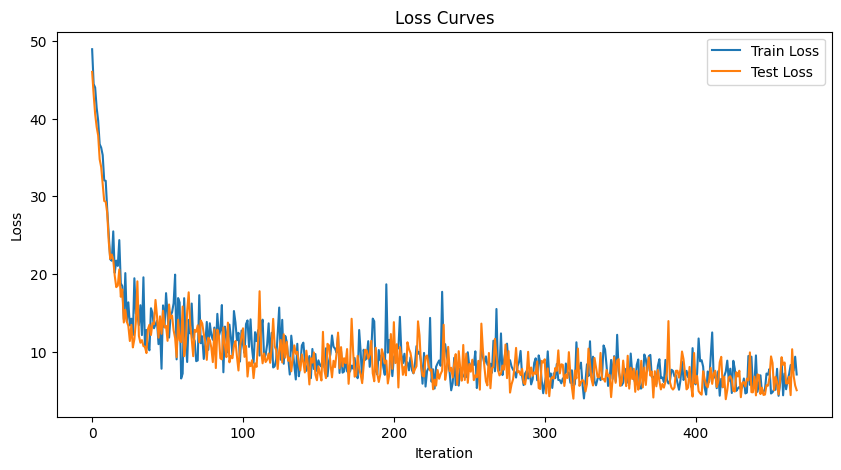

In [20]:
# plot loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [25]:
total = 0
correct = 0
testing_loader = DataLoader(testing_set, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
  net.eval()
  for data, targets in testing_loader:
    data = data.to(device)
    targets = targets.to(device)

    test_spk, _ = net(data.view(data.size(0), -1))

    # calculate total accuracy
    _, predicted = test_spk.sum(dim=0).max(1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

  print(f"total correctly classified test set images: {correct}/{total}")
  print(f"test accuracy: {100 * correct /total:.2f}%")

total correctly classified test set images: 9384/10000
test accuracy: 93.84%
